In [168]:
import torch
from importlib import reload
import ccc_nn_functions
from ccc_nn_functions import get_iterators,train_ccc_model, load_model, evaluate, get_predictions, plot_confusion_matrix
ccc_nn_functions = reload(ccc_nn_functions)

In [166]:
print('GPU is enabled:',torch.cuda.is_available())

GPU is enabled: True


In [174]:
#Train a model

# Data path
df_821_short_path = r'C:\Users\rz200\Documents\Development\cell-SCT\classification\imported_CSV\dataframe_821_short'
df_821_path = r'C:\Users\rz200\Documents\Development\cell-SCT\classification\imported_CSV\dataframe_821'
data_path = df_821_path #path to your data

# Path to save model
path_to_save = r'C:\Users\rz200\Documents\Development\cell-SCT\classification\saved_models\test_model.pt' #path to which you want to save your model

# Training the model
iterators = get_iterators(data_path) #get the iterators: data train-test-val formatted
num_epochs = 3
train_ccc_model(num_epochs,path_to_save,iterators) #train the model
model = load_model(path_to_save) #load your model you just trained

C:\Users\rz200\Documents\Development\cell-SCT\classification\ccc_nn_functions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ast.literal_eval(s))


Training examples: 91069 | Validation example: 10119 | Testing examples: 25298
The model has 61,111 trainable parameters
Torch Cuda is available: True


Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/1423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 46s | Train Loss: 0.830 | Train Acc: 62.96% | Val. Loss: 0.775 |  Val. Acc: 64.89%


Training:   0%|          | 0/1423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 50s | Train Loss: 0.770 | Train Acc: 65.31% | Val. Loss: 0.752 |  Val. Acc: 65.73%


Training:   0%|          | 0/1423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/159 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 49s | Train Loss: 0.755 | Train Acc: 65.99% | Val. Loss: 0.762 |  Val. Acc: 64.84%


Evaluating:   0%|          | 0/396 [00:00<?, ?it/s]

Test Loss: 0.754 | Test Acc: 65.65%


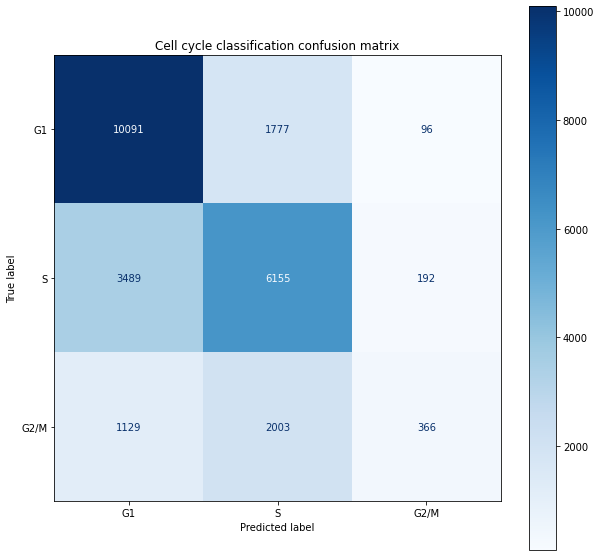

In [175]:
#Evaluate your model on your test data
test_iterator = iterators[2]
test_loss, test_acc = evaluate(model, test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

#Confusion matrix
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
plot_confusion_matrix(labels, pred_labels)

In [ ]:
#Now we should make all of this a pipeline where you just need to give the CSV file. Done
#Also we should have a prediction function. Already done
#Later on we need to modify this to be a mask to add on the segmented cells
    #The input to the network has to be an image made just from the segmentation mask of the cell, and the rest is padded to be squared, so no background
    #The cells need to be kept with an index for the segmentation mask of the cell to be brought back as labelled in the end

In [ ]:
#I should try making a better segmentation model with CellPose2, then segmenting out the cells from both plates into two CSVs that we then put together, and then training this classification model

In [ ]:
#Try the same model but with the CyclinA2 crops

In [ ]:
#make a model to try and guess the DAPI, CyclinA2 and EdU values just from the PCNA values

In [ ]:
#Next steps
 #Add a 'column name' input to choose which channel crops we want to train the model on
 #Add a function to just give a cell image and it gets the segmentation and it gets the predictions of all of its cells as a mask, it should keep the coordinates of the cell crops it makes
 #Change the model to only take the segmentation mask to make the prediction, not the crops
 #Make a new notebook that presents all of these functions together as a single pipeline
 #Make a GUI that presents the cell masks and we can hover over a cell to showcase it and it would give its cell phase